In [81]:
import csv
import json
import os
import os.path
import pickle as pkl
from pprint import pprint

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torchutils
from tqdm import tqdm


In [82]:
def load_json(fn):
    with open(fn, "r") as f:
        data = json.load(f)
    return data

In [83]:
inputDir = "release"
outputDir = "processed"

In [84]:
# all imgages saved in item_id.jpg format
image_files = torchutils.files.scan_files(f"{inputDir}/images", suffix="jpg")
print("Nubmer of images: {:,}".format(len(image_files)))

Nubmer of images: 261,057


In [85]:
metaData = torchutils.io.load_json(f"{inputDir}/polyvore_item_metadata.json")

item = np.random.choice(list(metaData.values()))
print("Number of items: {}".format(len(metaData)))
print("{:=^30}".format(" Example item "))
pprint(item)

# item id to item semantic category
itemType = {}

# fine grained categories to semantic category
fineGrained2Semantic = dict()

# set of all semantic categories
semanticSet = set()
for k, v in metaData.items():
    semanticSet.add(v["semantic_category"])
    fineGrained2Semantic[v["category_id"]] = v["semantic_category"]
    itemType[k] = v["semantic_category"]



# smenatic to id
semanticDict = dict()
for cate in sorted(semanticSet):
    semanticDict[cate] = len(semanticDict)

print("Number of items: %d" % len(metaData))
print("Number of categories: {}".format(len(fineGrained2Semantic)))

print("Semantic type to id")
pprint(semanticDict)

itemList = [set() for _ in range(len(semanticSet))]


Number of items: 251008
======== Example item ========
{'category_id': '105',
 'catgeories': '',
 'description': '',
 'related': '',
 'semantic_category': 'scarves',
 'title': '',
 'url_name': 'double print scarf'}
Number of items: 251008
Number of categories: 153
Semantic type to id
{'accessories': 0,
 'all-body': 1,
 'bags': 2,
 'bottoms': 3,
 'hats': 4,
 'jewellery': 5,
 'outerwear': 6,
 'scarves': 7,
 'shoes': 8,
 'sunglasses': 9,
 'tops': 10}


# Reformat the outfit tuples


In [86]:
dataSet = "nondisjoint"
dataSet = "disjoint"
src_dir = os.path.join(inputDir, dataSet)
dst_dir = os.path.join(outputDir, dataSet)

if not os.path.exists(dst_dir):
    os.mkdir(dst_dir)

with open(f"{inputDir}/{dataSet}/typespaces.p", "rb") as f:
    types = pkl.load(f)

print("Number of conditions:", len(types))
data = [[i, j, "+"] for i, j in (types)]
df = pd.DataFrame(data)

df.pivot(index=0, columns=1, values=2)

Number of conditions: 66


1,accessories,all-body,bags,bottoms,hats,jewellery,outerwear,scarves,shoes,sunglasses,tops
0,,,,,,,,,,,
accessories,+,+,NaN,+,NaN,NaN,+,+,NaN,NaN,NaN
all-body,NaN,+,NaN,+,NaN,NaN,+,+,NaN,NaN,NaN
bags,+,+,+,+,+,+,+,+,+,+,+
bottoms,NaN,NaN,NaN,+,NaN,NaN,+,+,NaN,NaN,NaN
hats,+,+,NaN,+,+,NaN,+,+,NaN,+,+
jewellery,+,+,NaN,+,+,+,+,+,NaN,+,+
outerwear,NaN,NaN,NaN,NaN,NaN,NaN,+,NaN,NaN,NaN,NaN
scarves,NaN,NaN,NaN,NaN,NaN,NaN,+,+,NaN,NaN,NaN
shoes,+,+,NaN,+,+,+,+,+,+,+,+


In [87]:
trainOutfits = torchutils.io.load_json(os.path.join(src_dir, "train.json"))
validOutfits = torchutils.io.load_json(os.path.join(src_dir, "valid.json"))
testOutfits = torchutils.io.load_json(os.path.join(src_dir, "test.json"))

allOutfits = trainOutfits + validOutfits + testOutfits
outfit = np.random.choice(allOutfits)
print(
    "Number of {} outfits: {} = train ({}) + valid({}) + test({})".format(
        dataSet, len(allOutfits), len(trainOutfits), len(validOutfits), len(testOutfits)
    )
)
print("Example outfit")
pprint(outfit)

MAX_SIZE = 0
for outfit in allOutfits:
    MAX_SIZE = max(MAX_SIZE, len(outfit["items"]))
print("Number of items (max): {}".format(MAX_SIZE))


Number of disjoint outfits: 35140 = train (16995) + valid(3000) + test(15145)
Example outfit
{'items': [{'index': 1, 'item_id': '163767019'},
           {'index': 2, 'item_id': '181657980'},
           {'index': 3, 'item_id': '138610347'},
           {'index': 4, 'item_id': '179808365'}],
 'set_id': '214251486'}
Number of items (max): 16


In [88]:
itemList = [set() for _ in range(len(semanticSet))]

for outfit in allOutfits:
    items = outfit["items"]
    for item in outfit["items"]:
        item_id = item["item_id"]
        item_type = itemType[item_id]
        type_id = semanticDict[item_type]
        itemList[type_id].add(item_id)

itemList = [list(items) for items in itemList]
itemIndex = []
for items in itemList:
    itemIndex.append({key: index for index, key in enumerate(items)})
print(list(map(len, itemList)))

torchutils.io.save_json(f"{dst_dir}/items.json", itemList)


[3904, 11783, 25287, 16752, 3463, 24506, 10111, 2732, 28534, 6152, 19561]


In [89]:
def count_items(outfits):
    sizes = [len(o["items"]) for o in outfits]
    return sizes


def count_conditions(outfits):
    conditions = set()
    for outfit in outfits:
        items = outfit["items"]
        size = len(items)
        for i in range(size):
            for j in range(size):
                id_i = items[i]["item_id"]
                id_j = items[j]["item_id"]
                if (itemType[id_i], itemType[id_j]) in conditions:
                    continue
                if (itemType[id_j], itemType[id_i]) in conditions:
                    continue
                conditions.add((itemType[id_i], itemType[id_j]))
    return conditions



Number conditions: 66


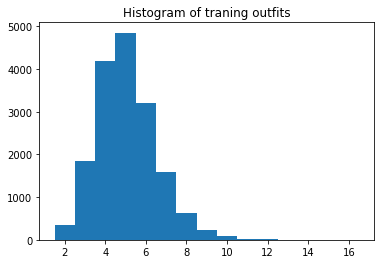

In [90]:
plt.hist(count_items(trainOutfits), bins=np.arange(MAX_SIZE) + 1.5)
plt.title("Histogram of traning outfits")
train_conditions = count_conditions(trainOutfits)
print("Number conditions: %d" % len(train_conditions))
# pprint(train_conditions)


Number conditions: 66


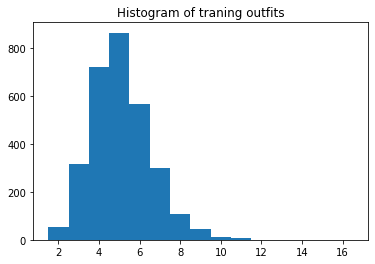

In [91]:
plt.hist(count_items(validOutfits), bins=np.arange(MAX_SIZE) + 1.5)
plt.title("Histogram of traning outfits")
valid_conditions = count_conditions(validOutfits)
print("Number conditions: %d" % len(valid_conditions))
# pprint(valid_conditions)


Number conditions: 66


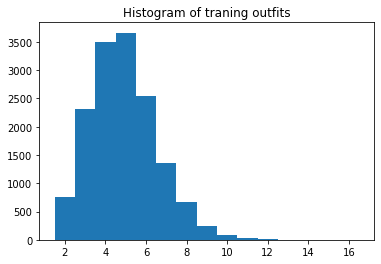

In [92]:
plt.hist(count_items(testOutfits), bins=np.arange(MAX_SIZE) + 1.5)
plt.title("Histogram of traning outfits")
test_conditions = count_conditions(testOutfits)
print("Number conditions: %d" % len(test_conditions))
# pprint(test_conditions)


In [93]:
def convert_tuples(outfits, max_size):
    tuples = []
    for outfit in outfits:
        items = outfit["items"]
        size = len(items)
        m = max_size - size
        item_ids = [i["item_id"] for i in items]
        types = [semanticDict[itemType[i]] for i in item_ids]
        items = [itemIndex[c][i] for c, i in zip(types, item_ids)]
        tuples.append([0, size] + items + [-1] * m + types + [-1] * m)
    return np.array(tuples)


In [94]:
trainTuples = convert_tuples(trainOutfits, MAX_SIZE)
validTuples = convert_tuples(validOutfits, MAX_SIZE)
testTuples = convert_tuples(testOutfits, MAX_SIZE)


In [95]:
with open(os.path.join(dst_dir, "train_pos"), "w") as f:
    writer = csv.writer(f)
    writer.writerows(trainTuples)

with open(os.path.join(dst_dir, "valid_pos"), "w") as f:
    writer = csv.writer(f)
    writer.writerows(validTuples)

with open(os.path.join(dst_dir, "test_pos"), "w") as f:
    writer = csv.writer(f)
    writer.writerows(testTuples)


In [96]:
name2Id = dict()
itemSet = set()
# since all items saved in item_id format, we do not need to check the content
for outfit in allOutfits:
    set_id = outfit["set_id"]
    for item in outfit["items"]:
        item_id = item["item_id"]
        index = item["index"]
        name = "{}_{}".format(set_id, index)
        name2Id[name] = item_id
        itemSet.add(item_id)
print("Number of items: {}, unique items: {}".format(len(name2Id), len(itemSet)))


Number of items: 175485, unique items: 152785


In [97]:
def compatibility(fn):
    pos_tuples = []
    neg_tuples = []
    with open(fn) as f:
        lines = f.readlines()
    for line in tqdm(lines):
        label, *outfit = line.split()
        tpl = [-1] * (2 * MAX_SIZE)
        for n, item in enumerate(outfit):
            item_id = name2Id[item]
            item_type = semanticDict[itemType[item_id]]
            tpl[n] = itemIndex[item_type][item_id]
            tpl[n + MAX_SIZE] = item_type
        tpl = [0, len(outfit)] + tpl
        if int(label) == 1:
            pos_tuples.append(tpl)
        else:
            neg_tuples.append(tpl)
    return np.array(pos_tuples), np.array(neg_tuples)



In [98]:
splits = ["train", "valid", "test"]
outfits = dict(train=trainTuples, valid=validTuples, test=testTuples)

for phase in splits:
    compatibility_fn = os.path.join(src_dir, "compatibility_{}.txt".format(phase))
    pos_tuples, neg_tuples = compatibility(compatibility_fn)
    assert (pos_tuples == outfits[phase]).all()
    # save negative outfits into files
    print(f"Number of {phase} positive outfits: {len(pos_tuples)}")
    print(f"Number of {phase} negative outfits: {len(neg_tuples)}")
    torchutils.io.save_csv(f"{dst_dir}/{phase}_neg", neg_tuples)


100%|██████████| 33990/33990 [00:00<00:00, 124752.48it/s]


Number of train positive outfits: 16995
Number of train negative outfits: 16995


  0%|          | 0/30290 [00:00<?, ?it/s]

Number of valid positive outfits: 3000
Number of valid negative outfits: 3000


100%|██████████| 30290/30290 [00:00<00:00, 131633.83it/s]


Number of test positive outfits: 15145
Number of test negative outfits: 15145


In [99]:
pos_set = {
    "train": set(map(tuple, trainTuples)),
    "valid": set(map(tuple, validTuples)),
    "test": set(map(tuple, testTuples)),
}


def convert_fitb(phase):
    positive_set = pos_set[phase]
    fn = os.path.join(src_dir, "fill_in_blank_{}.json".format(phase))
    with open(fn) as f:
        data = json.load(f)
    tuples = []
    for d in tqdm(data):
        position = d["blank_position"]
        question = d["question"]
        question_ids = [name2Id[i] for i in question]
        question_types = [semanticDict[itemType[i]] for i in question_ids]
        question_items = [itemIndex[c][i] for c, i in zip(question_types, question_ids)]
        n = len(question) + 1
        m = MAX_SIZE - n
        one_question = []
        for ans in d["answers"]:
            items = question_items.copy()
            types = question_types.copy()
            ans_id = name2Id[ans]
            ans_type = semanticDict[itemType[ans_id]]
            ans_item = itemIndex[ans_type][ans_id]
            items.insert(position - 1, ans_item)
            types.insert(position - 1, ans_type)
            ques_tpl = [0, n] + items + [-1] * m + types + [-1] * m
            if tuple(ques_tpl) in positive_set:
                one_question.insert(0, ques_tpl)
            else:
                one_question.append(ques_tpl)
        tuples += one_question
    tuples = np.array(tuples)
    return tuples


In [100]:
splits = ["train", "valid", "test"]
for phase in splits:
    tuples = convert_fitb(phase)
    print(f"Number of {phase} questions: {len(tuples) // 4}")
    torchutils.io.save_csv(f"{dst_dir}/{phase}_fitb", tuples)



100%|██████████| 16995/16995 [00:00<00:00, 41783.80it/s]


Number of train questions: 16995


 21%|██▏       | 3245/15145 [00:00<00:00, 32444.69it/s]

Number of valid questions: 3000


100%|██████████| 15145/15145 [00:00<00:00, 16306.21it/s]


Number of test questions: 15145
